# Test feasibility XAI for Random Forest in pyspark

In [2]:
#  import sys
#  !{sys.executable} -m pip install pyspark

  Using cached pyspark-3.4.1.tar.gz (310.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285415 sha256=e172650900d87f110c9e10c29775738ee673fbf575f89e8d186498a7df55f50d
  Stored in directory: c:\users\isharau\appdata\local\pip\cache\wheels\53\fe\23\517784b9d9dadfb82c5676e76483422096aa5dc20d4d602213
Successfully built pyspark


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import *
from pyspark.sql.functions import weekofyear
from pyspark.sql.functions import month
from pyspark.sql.functions import sum,avg,max
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql import functions as F
from pyspark.sql.functions import lag

In [2]:
spark= SparkSession \
       .builder \
       .appName("XAIspark") \
       .getOrCreate()


https://www.kaggle.com/code/hellbuoy/online-retail-k-means-hierarchical-clustering/notebook

In [3]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
# import sys
# !{sys.executable} -m pip install pyarrow

In [7]:
import pyspark.sql.functions as f


In [8]:
retail = spark.read.format("csv").option("header", "true").load("data/OnlineRetail.csv")

In [9]:
type(retail)

pyspark.sql.dataframe.DataFrame

In [10]:
print((retail.count(), len(retail.columns)))

(541909, 8)


## Data cleaning 

In [11]:
# Calculating the Missing Values % contribution in DF
 
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
retail.select([count(when(isnan(c)| col(c).isNull(), c)).alias(c) for c in retail.columns]
   ).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [12]:
# Droping rows having missing values

retail = retail.dropna()
print((retail.count(), len(retail.columns)))

(406829, 8)


In [66]:
# New Attribute : Monetary

retail = retail.withColumn('Amount' , f.col('Quantity')*f.col('UnitPrice'))

rfm_m = retail.groupBy('CustomerID').agg(f.sum('Amount').alias('Amount'))

#rfm_m = rfm_m.reset_index()
rfm_m.show(5)

+----------+------------------+
|CustomerID|            Amount|
+----------+------------------+
|     16250|            389.44|
|     15574| 702.2500000000002|
|     15555| 4758.200000000002|
|     15271|2485.8199999999997|
|     17714|             153.0|
+----------+------------------+
only showing top 5 rows



In [67]:
# New Attribute : Frequency
rfm_f = retail.groupBy('CustomerID').agg(f.count('InvoiceNo').alias('Frequency'))

#rfm_f = rfm_f.reset_index()
rfm_f.select('CustomerID', 'Frequency').show(5)
rfm_f = rfm_f.select('CustomerID', 'Frequency')

+----------+---------+
|CustomerID|Frequency|
+----------+---------+
|     16250|       24|
|     15574|      168|
|     15555|      925|
|     15271|      275|
|     17714|       10|
+----------+---------+
only showing top 5 rows



In [82]:
# Merging the two dfs

rfm = rfm_m.join(rfm_f, on='CustomerID', how='inner')
rfm.show(5)

+----------+------------------+---------+
|CustomerID|            Amount|Frequency|
+----------+------------------+---------+
|     16250|            389.44|       24|
|     15574| 702.2500000000002|      168|
|     15555| 4758.200000000002|      925|
|     15271|2485.8199999999997|      275|
|     17714|             153.0|       10|
+----------+------------------+---------+
only showing top 5 rows



In [83]:
# New Attribute : Recency

# Convert to datetime to proper datatype
retail = retail.withColumn("InvoiceDate", to_timestamp(f.col('InvoiceDate'), 'dd-MM-yyyy HH:mm'))

retail.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+-------------------+----+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|            Amount|           max_date|Diff|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+-------------------+----+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|15.299999999999999|2011-12-09 12:50:00| 373|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|             20.34|2011-12-09 12:50:00| 373|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|              22.0|2011-12-09 12:50:00| 373|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|     17

In [84]:
# Compute the maximum date to know the last transaction date

max_date = retail.agg(f.max('InvoiceDate')).take(1)[0][0]
max_date

datetime.datetime(2011, 12, 9, 12, 50)

In [85]:
# Compute the difference between max date and transaction date

retail = (retail
          .withColumn('max_date' , f.lit(max_date))
          .withColumn('Diff' ,  f.datediff(f.col('max_date'), f.col('InvoiceDate'))))

retail.select('InvoiceDate' , 'max_date' , 'Diff').show(5)

+-------------------+-------------------+----+
|        InvoiceDate|           max_date|Diff|
+-------------------+-------------------+----+
|2010-12-01 08:26:00|2011-12-09 12:50:00| 373|
|2010-12-01 08:26:00|2011-12-09 12:50:00| 373|
|2010-12-01 08:26:00|2011-12-09 12:50:00| 373|
|2010-12-01 08:26:00|2011-12-09 12:50:00| 373|
|2010-12-01 08:26:00|2011-12-09 12:50:00| 373|
+-------------------+-------------------+----+
only showing top 5 rows



In [86]:
# Compute last transaction date to get the recency of customers
rfm_p = (retail
         .groupby('CustomerID')
         .agg(f.min('Diff').alias('Recency'))
        )
rfm_p.show(5)

+----------+-------+
|CustomerID|Recency|
+----------+-------+
|     16250|    261|
|     15574|    177|
|     15555|     12|
|     15271|      7|
|     17714|    320|
+----------+-------+
only showing top 5 rows



In [87]:
# Merge tha dataframes to get the final RFM dataframe

rfm = rfm.join(rfm_p, on='CustomerID', how='inner')
rfm = rfm.select('CustomerID', 'Amount', 'Frequency', 'Recency')
rfm.show(5)

+----------+------------------+---------+-------+
|CustomerID|            Amount|Frequency|Recency|
+----------+------------------+---------+-------+
|     16250|            389.44|       24|    261|
|     15574| 702.2500000000002|      168|    177|
|     15555| 4758.200000000002|      925|     12|
|     15271|2485.8199999999997|      275|      7|
|     17714|             153.0|       10|    320|
+----------+------------------+---------+-------+
only showing top 5 rows



## Handling Outliers

In [88]:
quantiles = rfm.approxQuantile("Amount", [0.05, 0.95], 0)
quantiles

[101.10000000000001, 5639.15]

In [89]:
# Removing (statistical) outliers for Amount
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

rfm = rfm.filter((f.col('Amount') >= Q1 - 1.5*IQR ) & (f.col('Amount') <= Q3 + 1.5*IQR ) ) 

print((rfm.count(), len(rfm.columns)))

(4314, 4)


In [90]:
# Removing (statistical) outliers for Amount
quantiles = rfm.approxQuantile("Amount", [0.05, 0.95], 0)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

rfm = rfm.filter((f.col('Amount') >= Q1 - 1.5*IQR ) & (f.col('Amount') <= Q3 + 1.5*IQR ) ) 

print((rfm.count(), len(rfm.columns)))
# Removing (statistical) outliers for Recency
quantiles = rfm.approxQuantile("Recency", [0.05, 0.95], 0)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

rfm = rfm.filter((f.col('Recency') >= Q1 - 1.5*IQR ) & (f.col('Recency') <= Q3 + 1.5*IQR ) ) 
print((rfm.count(), len(rfm.columns)))

# Removing (statistical) outliers for Frequency
quantiles = rfm.approxQuantile("Frequency", [0.05, 0.95], 0)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

rfm = rfm.filter((f.col('Frequency') >= Q1 - 1.5*IQR ) & (f.col('Frequency') <= Q3 + 1.5*IQR ) ) 
print((rfm.count(), len(rfm.columns)))

(4301, 4)
(4301, 4)
(4281, 4)


In [92]:
feature_cols = ['Amount', 'Frequency', 'Recency']

## Vector Assembling

In [93]:
#vector assembler 
from pyspark.ml.feature import VectorAssembler

assemble       = VectorAssembler(inputCols= feature_cols, outputCol='features', handleInvalid="keep")
assembled_data = assemble.transform(rfm)

In [94]:
assembled_data.show(5)

+----------+------------------+---------+-------+--------------------+
|CustomerID|            Amount|Frequency|Recency|            features|
+----------+------------------+---------+-------+--------------------+
|     16250|            389.44|       24|    261| [389.44,24.0,261.0]|
|     15574| 702.2500000000002|      168|    177|[702.250000000000...|
|     15271|2485.8199999999997|      275|      7|[2485.81999999999...|
|     17714|             153.0|       10|    320|  [153.0,10.0,320.0]|
|     17551|            306.84|       43|    359| [306.84,43.0,359.0]|
+----------+------------------+---------+-------+--------------------+
only showing top 5 rows



## Rescaling the attributes

In [95]:
from pyspark.ml.feature import StandardScaler
scale= StandardScaler(inputCol='features',outputCol='Scaled_features')  #save this and load 
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [96]:
data_scale_output.show(5)

+----------+------------------+---------+-------+--------------------+--------------------+
|CustomerID|            Amount|Frequency|Recency|            features|     Scaled_features|
+----------+------------------+---------+-------+--------------------+--------------------+
|     16250|            389.44|       24|    261| [389.44,24.0,261.0]|[0.23658248201602...|
|     15574| 702.2500000000002|      168|    177|[702.250000000000...|[0.42661269514110...|
|     15271|2485.8199999999997|      275|      7|[2485.81999999999...|[1.51012085416256...|
|     17714|             153.0|       10|    320|  [153.0,10.0,320.0]|[0.09294658932942...|
|     17551|            306.84|       43|    359| [306.84,43.0,359.0]|[0.18640347365909...|
+----------+------------------+---------+-------+--------------------+--------------------+
only showing top 5 rows



## Building the Model - Unsupervised learning - KMeans model

In [99]:
from pyspark.ml.clustering import KMeans
kmeans=KMeans(featuresCol = 'Scaled_features' , k = 8)
knn_model = kmeans.fit(data_scale_output.select('Scaled_features'))

In [100]:
transformed = knn_model.transform(data_scale_output)

In [102]:
transformed.show(5)

+----------+------------------+---------+-------+--------------------+--------------------+----------+
|CustomerID|            Amount|Frequency|Recency|            features|     Scaled_features|prediction|
+----------+------------------+---------+-------+--------------------+--------------------+----------+
|     16250|            389.44|       24|    261| [389.44,24.0,261.0]|[0.23658248201602...|         0|
|     15574| 702.2500000000002|      168|    177|[702.250000000000...|[0.42661269514110...|         4|
|     15271|2485.8199999999997|      275|      7|[2485.81999999999...|[1.51012085416256...|         2|
|     17714|             153.0|       10|    320|  [153.0,10.0,320.0]|[0.09294658932942...|         0|
|     17551|            306.84|       43|    359| [306.84,43.0,359.0]|[0.18640347365909...|         0|
+----------+------------------+---------+-------+--------------------+--------------------+----------+
only showing top 5 rows



In [105]:
summary = (transformed.groupBy("prediction")
            .agg(f.countDistinct("CustomerID").alias("count"),
                 f.avg("Amount").alias("Amount"),
                 f.avg("Recency").alias("Recency"),
                 f.avg("Frequency").alias("Frequency")               
                )
            .withColumn('client %',( f.col('count')/f.sum('count').over(Window.partitionBy()) )*100   )
            .withColumn('sales %',( f.col('Amount')/f.sum('Amount').over(Window.partitionBy()) )*100  )  
          )
    
summary.show()

+----------+-----+------------------+------------------+------------------+------------------+------------------+
|prediction|count|            Amount|           Recency|         Frequency|          client %|           sales %|
+----------+-----+------------------+------------------+------------------+------------------+------------------+
|         1| 1583| 532.1449292482622| 40.45041061276058| 31.96778269109286|36.977341742583505|2.1444898873394145|
|         6|   88|2990.8739772727276|16.113636363636363|460.71590909090907|2.0555944872693295|12.052917628339731|
|         3|   85| 7594.468117647057|              13.2|393.83529411764704| 1.985517402476057|30.604933323376017|
|         5|   58| 7893.434137931034|38.672413793103445|114.91379310344827|1.3548236393366035|31.809735947470912|
|         4|  697|511.30067431850756|163.94117647058823|31.319942611190818|16.281242700303665| 2.060489662120451|
|         7|  793|1618.7298486759144|32.939470365699876|107.45649432534678| 18.523709413

## Building the Model - Supervised learning -Random forest model

In [108]:

final_data =(transformed
             .withColumnRenamed("prediction", "Cluster_ID")
             .select('Scaled_features','Cluster_ID')
            )

In [109]:
#Splitting train and test data
train, test = final_data.randomSplit([0.75,0.25], seed = 25)

In [110]:
from pyspark.ml.classification import RandomForestClassifier
rf  = RandomForestClassifier(featuresCol = 'Scaled_features', labelCol = 'Cluster_ID', maxDepth = 10)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

## Evaluation

In [111]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol = "Cluster_ID", predictionCol = "prediction" , metricName = "accuracy")
evaluator.evaluate(predictions)

0.9487179487179487

In [117]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator2 = ClusteringEvaluator( featuresCol = "Scaled_features", predictionCol = "prediction" ,metricName = "silhouette")
evaluator2.evaluate(predictions)

0.5394299880873227

In [ ]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans=KMeans(featuresCol = 'Scaled_features' , k = num_clusters)
    knn_model = kmeans.fit(data_scale_output.select('Scaled_features'))
    transformed = knn_model.transform(data_scale_output)
   
    
    # silhouette score
    evaluator2 = ClusteringEvaluator( featuresCol = "Scaled_features", predictionCol = "prediction" ,metricName = "silhouette")
    silhouette_avg = evaluator2.evaluate(transformed)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

## XAI

In [166]:
import shap
import pyspark 
import pyspark.pandas as ps

# def spark_shape(self):
#     return self.toPandas().shape

# pyspark.sql.dataframe.DataFrame.shape = spark_shape

In [318]:
X=rfm.select(*feature_cols)
# X2 = ps.DataFrame(X)


#pyspark.pandas.DataFrame.dtypes = pyspark.pandas.Series.dtype

In [295]:
# def spark_reshape(self):
#     return self.toPandas().reshape

# pyspark.sql.dataframe.DataFrame.reshape = spark_reshape

In [319]:
X2 = X.toPandas()

# This is because we are using random forest in pyspark not sklearn

check_additivity requires us to run predictions which is not supported with spark, ignoring. Set check_additivity=False to remove this warning


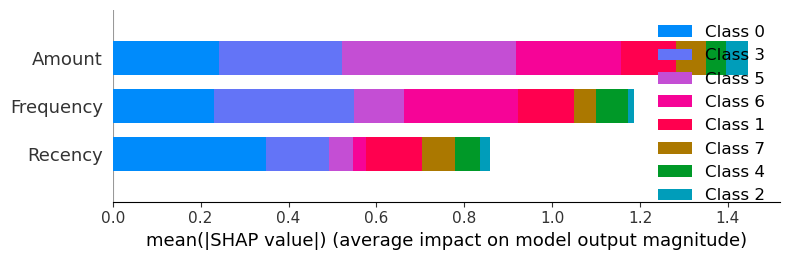

In [316]:
# Generate the Tree explainer and SHAP values
explainer = shap.TreeExplainer(rfModel)
shap_values = explainer.shap_values(X2)
expected_value = explainer.expected_value

############## visualizations #############
# Generate summary dot plot
shap.summary_plot(shap_values, X2,title="SHAP summary plot") 

In [ ]:
# Generate Decision plot 
(shap.decision_plot(expected_value, shap_values[5],link='logit',
                features=X2.loc[5,:], 
                feature_names=(X2.columns.tolist()),
                show=True,
                title="Decision Plot"))

In [317]:
# Generate waterfall plot  
(shap
 .plots
 .waterfall(shap_values[0])
 )

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

In [310]:
# Generate waterfall plot  
(shap
 .plots
 ._waterfall
 .waterfall_legacy(expected_value,
                   shap_values[3],
                   features=X2.loc[3,:],
                   feature_names=X2.columns,
                   max_display=15,
                   show=True))

Exception: waterfall_plot requires a scalar expected_value of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.expected_value[0], shap_values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0], X[0]).

In [320]:
# visualize the first prediction's explaination with default colors
shap.force_plot(explainer.expected_value, shap_values[0,:], X2.iloc[0,:])

TypeError: list indices must be integers or slices, not tuple